# Introducción:
En este notebook se presenta la mejor solución encontrada al problema de clasificación asignado. Los datos, procedimientos y desarrollos mostrados son el resultado de los procedimientos implementados en el área de exploración de datos (ver notebook: analisis_exploratorio_datos.ipynb) y diversos experimentos con diferentes configuraciones de clasificación (experimentos_entrenamiento_clasificacion.ipynb).

In [103]:
# Librerias utlizadas:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE 

import matplotlib.pyplot as plt

Funciones útiles:

In [104]:
# Método para el cálculo del índice Gini normalizado:
def gini_normalized(y_actual, y_pred):
    """Simple normalized Gini based on Scikit-Learn's roc_auc_score"""
    gini = lambda a, p: 2 * metrics.roc_auc_score(a, p) - 1
    return gini(y_actual, y_pred) / gini(y_actual, y_actual)

## Datos de entrenamiento (train data):
En esta sección se cargan y muestran los datos de entrenamiento a utilizar. Adicionalmente se muestra una breve descripción de los datos; sin embargo, para mayor profundidad en su análisis se solicita revisar el notebook sobre análisis exploratorio de datos.

Cargando datos de entrenamiento:

In [105]:
train_df = pd.read_csv('./Datos/train.csv')
train_df.rename(columns={'Unnamed: 0':'first_col'}, inplace=True)
train_df

,first_col,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,ae61,ae62,ae63,ae64,ae65,ae66,ae67,ae68,d69,d70
0,1651,0.00,143270.10,100.0,0.0,0.0,63090564.44,4199850.00,0.00,6240000.0,...,0,0,0,0,0,0,0,0,0,0
1,1370,0.00,1403461.97,90.0,10.0,29.0,8013913.78,8177030.69,44951.90,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2649,19800.24,63401.41,100.0,0.0,0.0,323384.60,67610.22,0.00,0.0,...,1,0,0,0,0,0,0,0,1,0
3,564,0.00,10585032.22,100.0,0.0,5.0,29596681.95,186964.54,0.00,4500000.0,...,0,0,0,0,0,0,0,0,0,0
4,2728,0.00,11259663.09,78.0,22.0,0.0,33626595.71,0.00,0.00,3972827.7,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2184,2732,0.00,0.00,100.0,0.0,0.0,17321789.44,6502334.11,0.00,4800000.0,...,0,0,0,0,0,0,0,1,0,0
2185,2069,0.00,148821.45,100.0,0.0,5.0,17874738.23,805330.00,0.00,4279059.0,...,0,0,0,0,0,0,0,1,0,0
2186,1018,0.00,6438.10,0.0,0.0,0.0,0.00,0.00,0.00,0.0,...,1,0,0,0,0,0,0,0,1,0
2187,2323,0.00,1309077.66,91.0,9.0,12.0,7757433.99,9312203.53,19156.47,0.0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
# train_df.info(verbose=True)

In [107]:
train_df.describe()

,first_col,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,ae61,ae62,ae63,ae64,ae65,ae66,ae67,ae68,d69,d70
count,2189.000000,2.189000e+03,2.189000e+03,2189.000000,2189.000000,2189.000000,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,...,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000,2189.0
mean,1457.217908,2.789336e+04,2.498074e+06,87.098675,10.317953,3.608040,7.332287e+07,1.011043e+07,1.126268e+04,2.283687e+06,...,0.034719,0.371859,0.004111,0.021928,0.004568,0.014619,0.007766,0.044312,0.122430,0.0
std,842.158691,2.770920e+05,3.713769e+06,29.548930,25.922405,8.477891,3.009257e+08,4.209394e+07,1.540442e+05,3.283374e+06,...,0.183109,0.483412,0.064003,0.146481,0.067450,0.120048,0.087803,0.205835,0.327857,0.0
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,731.000000,0.000000e+00,1.411988e+04,100.000000,0.000000,0.000000,2.898817e+06,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1453.000000,0.000000e+00,1.781006e+05,100.000000,0.000000,0.000000,1.623024e+07,1.970460e+04,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,2188.000000,0.000000e+00,3.958601e+06,100.000000,0.000000,5.000000,3.308427e+07,2.560791e+06,0.000000e+00,4.355600e+06,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,2907.000000,5.030246e+06,1.257078e+07,100.000000,100.000000,183.000000,3.283312e+09,4.415314e+08,2.427617e+06,1.000000e+07,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


Etiquetas del conjunto de entrenamiento (training labels):

In [108]:
train_labels_df = pd.read_csv('./Datos/train_label.csv', header=None)
train_labels_df.rename(columns={0:'train_labels'}, inplace=True)
train_labels_df

,train_labels
0,0.0
1,1.0
2,1.0
3,0.0
4,1.0
...,...
2184,0.0
2185,0.0
2186,0.0
2187,1.0


En resumen los datos de entrenamiento no presentan datos faltantes, presencia de variables categóricas o algún error que impida su procesamiento. Es importante notar la alta cantidad de variables binarias y una presencia siginificativa de "outliers" en éste tipo de datos.

## Datos de entrenamiento (train data):
En esta sección se cargan y muestran los datos de entrenamiento a utilizar. Adicionalmente se muestra una breve descripción de los datos; sin embargo, para mayor profundidad en su análisis se solicita revisar el notebook sobre análisis exploratorio de datos.

In [109]:
test_df = pd.read_csv('./Datos/test.csv')
test_df.rename(columns={'Unnamed: 0':'first_col'}, inplace=True)
test_df

,first_col,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,ae61,ae62,ae63,ae64,ae65,ae66,ae67,ae68,d69,d70
0,2269,0.00,0.10,29.0,71.0,0.0,4.206076e+07,2445379.88,0.0,8000000.0,...,0,0,0,0,0,0,0,1,0,0
1,2709,0.00,0.00,100.0,0.0,3.0,6.356591e+06,1151315.35,0.0,3798381.6,...,0,0,0,0,0,0,0,1,0,0
2,2345,0.00,0.00,100.0,0.0,0.0,1.834357e+08,8136692.18,0.0,8000000.0,...,0,0,0,0,0,0,0,0,0,0
3,2810,0.00,104207.83,100.0,0.0,0.0,7.515544e+07,4211350.00,0.0,6240000.0,...,0,0,0,0,0,0,0,0,0,0
4,1199,87791.71,460376.03,94.0,6.0,26.0,8.624776e+07,39737205.73,0.0,8000000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,1425,0.00,813216.41,100.0,0.0,0.0,1.642559e+07,0.00,0.0,3071719.0,...,0,0,0,0,0,0,0,0,0,0
544,223,0.00,39690.33,100.0,0.0,0.0,7.174000e+07,0.00,0.0,10000000.0,...,0,1,0,0,0,0,0,0,0,0
545,910,0.00,43754.09,100.0,0.0,0.0,9.366955e+07,0.00,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
546,2692,0.00,10484136.23,100.0,0.0,4.0,2.858129e+07,423747.53,0.0,4500000.0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
test_df.describe()

,first_col,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,ae61,ae62,ae63,ae64,ae65,ae66,ae67,ae68,d69,d70
count,548.000000,5.480000e+02,5.480000e+02,548.000000,548.000000,548.000000,5.480000e+02,5.480000e+02,5.480000e+02,5.480000e+02,...,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.0
mean,1452.828467,3.131216e+04,2.475192e+06,88.310219,10.020073,3.260949,9.132183e+07,1.111962e+07,5.233546e+03,2.527753e+06,...,0.038321,0.359489,0.003650,0.014599,0.010949,0.016423,0.007299,0.047445,0.125912,0.0
std,839.951933,3.151500e+05,3.807949e+06,27.723210,25.162753,6.730064,3.931913e+08,4.857652e+07,1.040392e+05,3.371184e+06,...,0.192146,0.480289,0.060357,0.120049,0.104158,0.127213,0.085201,0.212784,0.332054,0.0
min,6.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,705.500000,0.000000e+00,1.544488e+04,100.000000,0.000000,0.000000,4.736544e+06,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1470.500000,0.000000e+00,1.834499e+05,100.000000,0.000000,0.000000,1.642559e+07,1.150000e+04,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,2210.750000,0.000000e+00,3.567092e+06,100.000000,0.000000,5.000000,3.308427e+07,2.450080e+06,0.000000e+00,5.670000e+06,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,2908.000000,5.905906e+06,1.263579e+07,100.000000,100.000000,39.000000,3.105412e+09,4.381111e+08,2.427617e+06,1.000000e+07,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


Cargando etiquetas de validación (Loading test labels):

In [111]:
test_labels_df = pd.read_csv('./Datos/test_label.csv', header=None)
test_labels_df.rename(columns={0:'test_labels'}, inplace=True)
test_labels_df

,test_labels
0,0.0
1,0.0
2,0.0
3,0.0
4,1.0
...,...
543,0.0
544,0.0
545,0.0
546,0.0


## Etapa de clasificación: Entrenamiento y validación.

Teniendo en cuenta las características de los datos ofrecidos para este trabajo se diseñaron varias aproximaciones al problema de clasificación planteado. Las hipótesis de trabajo ideadas fueron puestas a prueba mediante el desarrollo de distintos experimentos que pueden ser consultados en detalle en el notebook "experimentos_entrenamiento_validación.ipynb".
A continuación se presenta la mejor metodología para atacar el problema de clasificación dado.

Cómo mejor solución al problema mostraremos una metodología basada en la eliminación de las variables binarias, el balanceo de los datos restantes y la clasificación mediante el algoritmo de "Random Forest Classifier" (Este procedimiento corresponde al experimento 6 realizado previamente).
La eliminación de las variables binarias se ofrece como alternativa ya que los trabajos implementados utilizando el conjunto completo de datos, mostró que estas variables generan los menores pesos en la toma de decisiones del algoritmo, por tanto no ayudan en gran medida a la solución que ser busca.

In [112]:
# Datos en formato numpy: 
train_data = train_df.values
train_labels = train_labels_df.values

In [113]:
# Extracción de las características (datos/features) a utlizar en el entrenamiento:

# numeric_features = train.select_dtypes(include=['int64', 'float64']).columns
selected_features = train_df.select_dtypes(include=['float64']).columns
reduced_train_df = train_df[selected_features]

print(f'Selected features: {selected_features.shape[0]}')
print(selected_features)
print(f'Original training dataset dimension = {train_df.shape}')
print(f'New training dataset dimension = {reduced_train_df.shape}')


Selected features: 36
Index(['v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30',
       'v31', 'v32', 'v34', 'v35', 'v36'],
      dtype='object')
Original training dataset dimension = (2189, 72)
New training dataset dimension = (2189, 36)


In [114]:
# Extracción de las características (datos/features) en los datos de test:
reduced_test_df = test_df[selected_features]
reduced_test_df.shape

(548, 36)

**Balanceo de datos para el conjunto de entrenamiento:**

In [115]:
# Instanciamos el método SMOTE para realizar el sobre-muestreo:
sm = SMOTE(random_state=40)

In [116]:
# Sobre-muestreo del conjunto de entrenamiento:
train_data_res, train_labels_res = sm.fit_resample(reduced_train_df.values, train_labels_df.values)

In [117]:
# Variables organizadas como arreglos de numpy (ndarray):
train_data_res.shape, train_labels_res.shape

((3520, 36), (3520,))

**Entrenamiento: Usamos los nuevos datos**

In [118]:
rfc2 = RandomForestClassifier(n_estimators=100).fit(train_data_res, train_labels_res)

Performance con los datos de entrenamiento:

In [119]:
train_predicts = rfc2.predict(train_data_res)
metrics.f1_score(train_labels_res, train_predicts), gini_normalized(train_labels_res, train_predicts)

(0.9878565377012144, 0.9755681818181816)

**Peso de las variables consideradas por el algoritmo de clasificación durante el entrenamiento:**

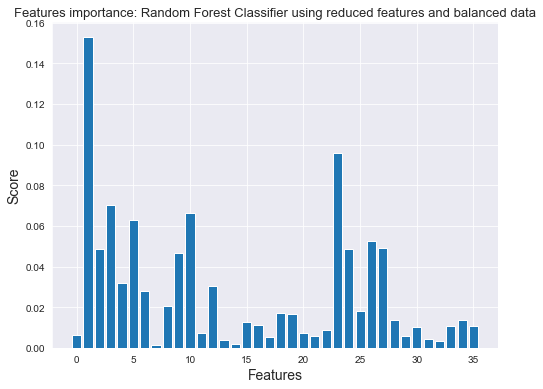

In [120]:
importance = rfc2.feature_importances_

# Resumen de la importancia de las variables de entrenamiento:
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.figure(figsize=(8, 6))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Features importance: Random Forest Classifier using reduced features and balanced data', fontsize=13)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Features", fontsize=14)
plt.show()

**Validación:**

In [121]:
# Predicciones usando el modelo entrenado:
rfc2_predictions = rfc2.predict(reduced_test_df.values)

In [122]:
pred_f1_score = metrics.f1_score(test_labels_df.values, rfc2_predictions)
pred_gini_score = gini_normalized(test_labels_df.values, rfc2_predictions)

print('Random Forest Classifier (using reduced data) for validation stage:')
print(f'f1-score = {pred_f1_score}')
print(f'Gini score = {pred_gini_score}')

Random Forest Classifier (using reduced data) for validation stage:
f1-score = 0.8303571428571429
Gini score = 0.8088383838383839


## Comentarios finales:

1) Par conocer cuales variables toman mayor peso en la descisión del algoritmo, en el caso del aquellos métodos basados en árboles de desición, es coveniente utilizar la función "feature_importances_". Este método se encarga de medir la importancia de cada variable utilizada mediante el cálculo de un factor basado en la métrica de Gini. Sin embargo, para esto es necesario entrenar el modelo y a partir de allí conocer esta información. \
En el caso de modelos más complejos puede ser utlizada la librería **SHAP (SHapley Additive exPlanations)** (https://shap.readthedocs.io/en/latest/index.html), desarrollada con el fin de interpretabilidad a los pesos y salidas de cualquier modelo de aprendizaje de máquina.

2) La aproximación final, presentada anteriormente, muestra ser una metodología pertinente para resolver el problema de clasificación presentado. Encontramos métricas de evaluación superiores al 80%. Sin embargo, durante el entrenamiento vemos valores muchos mas altos (cercanos al 100%) que tal vez puedan siginificar un sobre ajuste del modelo a los datos de entrenamiento.

3) Teniendo en cuenta el anterior comentario, se puede concluir que a pesar de tener una solución al problema de clasificación planteado, sería interesante realizar una mejora sobre los datos de trabajo ya que aportan información redundante y la relación entre el aprendizaje y el test no es la mejor.

4) Finalmente me gustaría establecer, como comentario personal, que es necesario mejorar el conjunto de datos dado para el trabajo ya que un 80% de precisión obtenido me parece poco cuando se trata de predecir si un crédito puede ser pagado a tiempo o no.